# Smartphone Detection

We aim at this notebook to perform the classification of a set of data that has several information about products that were collected on the internet. Our goal is to find a way to identify which texts refer to cell phones and which ones do not.


To do this we apply pre-processing and textual analysis techniques. At the end we created a classifier that could identify from the text description if its context refers to a smartphone or not.

In [1]:
# Import's

# Data manipulation
import pandas as pd
import numpy as np

# Text manipulation
from unidecode import unidecode
import string
import nltk
import re

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC

# Evaluation
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Deploy
from sklearn.pipeline import Pipeline
import pickle

In [2]:
# Reading data
e_commerce = pd.read_csv('data_estag_ds.tsv',sep='\t',usecols=[1])
e_commerce = e_commerce.rename(columns={'TITLE':'title'})

In [3]:
# First 5 lines
e_commerce.head()

,title
0,Acessório T - Jean Bag For Girls para DS Lite
1,Carrinho de Bebê Berço-Passeio - Pegasus Pink ...
2,Carrinho de Bebê para Gêmeos Berço-Passeio - T...
3,Car Center - Calesita
4,Donka Trem com Som - Calesita


In [4]:
# Number of samples
e_commerce.shape[0]

2606

# 1. Data Cleaning

Let's remove stopwords, punctuation and normalize text to get better information for analysis.

In [5]:
# Portuguese stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')

# Stemming in portuguese
stemmer = nltk.stem.RSLPStemmer()

'''

Cleaning text.

'''
def text_clean(doc,stemmer=False):
    
    # Creating tokens and remove accentuation
    token = nltk.word_tokenize(unidecode(doc.lower()),language='portuguese')
    
    # Stemming
    if(stemmer):
        token = [stemmer.stem(word) for word in token]
    
    # Remove stopwords
    token =  [word for word in token if word not in stopwords]  
    
    # Remove punctuation
    token = [word for word in token if word not in string.punctuation]
    
    return ' '.join(token)

In [6]:
# Cleaning text
e_commerce['title'] = e_commerce['title'].map(text_clean)

# 2. Text Analysis

So you can see that our dataset just have one column called 'title' and we have 2606 samples unlabeled. Knowing that I think in two possibilities to try to classifier our text:

- Clustering similar text.
- Label manually out text an them apply some classifier.

I will choose the second option for these reasons:
- It would be difficult to group ours because we do not know how many groups we have. Our text can be 10 groups or 50. Defining an ideal k number would be complicated.
- Also, our desire is to have only 2 groups (smartphone or not). So even if we knew the exact amount of groups (30 for example), we would have the difficulty to group non-smartphone groups to only 2 left.

Say this a better option it's understand what words an relations exist in text that talk about smartphone for using this knowledge to create a classifier.

So let's do some text analysis.

In [7]:
# Random text
e_commerce.sample(5,random_state=42)

,title
782,shampoo lorys kids red shake 500ml
786,capa rigida maquina fotografica cinza
602,mesa escolar infantil 92361000 tramontina
420,capa case samsung galaxy tab s 10.5 t800/801/8...
2319,celular samsung galaxy j5 prime 32gb biometria...


In [8]:
# Filter text by word smartphone
e_commerce[e_commerce['title'].map(lambda x: 'smartphone' in x)].head()

,title
6,smartphone lg optimus l7 ii dual p716 preto du...
7,smartphone samsung galaxy s4 mini duos preto d...
8,smartphone samsung galaxy s5 sm-g900m branco t...
9,smartphone samsung galaxy s5 sm-g900m dourado ...
10,smartphone lg l90 dual d410 preto tela 4.7 '' ...


Note that we have text about shampoo, school table and etc, that is, we have several information that are not related to smartphone. Filtering the data by smartphone we can see that we can find the samples that explicitly refer to it. However, not always the text will have that keyword indicating what the product is, we could have for example only samsung galaxy.

Because of this we will use this filtered subset to understand their relationships.

In [9]:
'''

Perform ngram in text

Parameters:
-----------
n: Number of ngram to use.
df: Series with text to process.
top: Number of top words to return.

Returns:
-----------
Dataframe with ngram count.

'''
def ngram(n,df,top=10):

    # Unigrams
    vec = CountVectorizer(ngram_range=(n,n)).fit(df)

    # Bag of words
    bag_of_words = vec.transform(df)

    # Sum each count
    sum_words = bag_of_words.sum(axis=0)

    # Frequency of each words
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort
    words_freq.sort(key=lambda x: x[1],reverse=True)

    # Create dataframe
    words_freq = pd.DataFrame(words_freq,columns=['word','freq'])
    
    return words_freq[:top]

In [10]:
# Filter text by word smartphone
smartphone = e_commerce[e_commerce['title'].map(lambda x: 'smartphone' in x)].copy()

# Separate datasets
e_commerce = e_commerce[~e_commerce.index.isin(smartphone.index)]

Before compute some ngram to understand relationships between words we will remove the key word 'smartphone'.

In [11]:
# Remove words smartphone
smartphone['title'] = smartphone['title'].map(lambda x: x.replace('smartphone',''))

In [12]:
# Unigram
unigram = ngram(1,smartphone['title'])

# Bigram
bigram = ngram(2,smartphone['title'])

In [13]:
'''

Plot ngram words.


Parameters:
-----------
x,y: Array with values to set in axis x,y.
title: Plot's title.

'''
def ngram_plot(x,y,title):
    
    # Creating figure
    fig,ax = plt.subplots(figsize=(12,7))
    sns.barplot(x=x,y=y,palette='Blues',ax=ax)

    ax.set_title(title,size=15)

    # Change xlabels/ylabels size
    ax.set_xlabel('Word',size=15)
    ax.set_ylabel('Freq',size=15)

    # Change and rotate xticklabels/yticklabels
    for tick_x in ax.get_xticklabels():
        tick_x.set_fontsize(13)
        tick_x.set_rotation(60)
    for tick_y in ax.get_yticklabels():
        tick_y.set_fontsize(13)

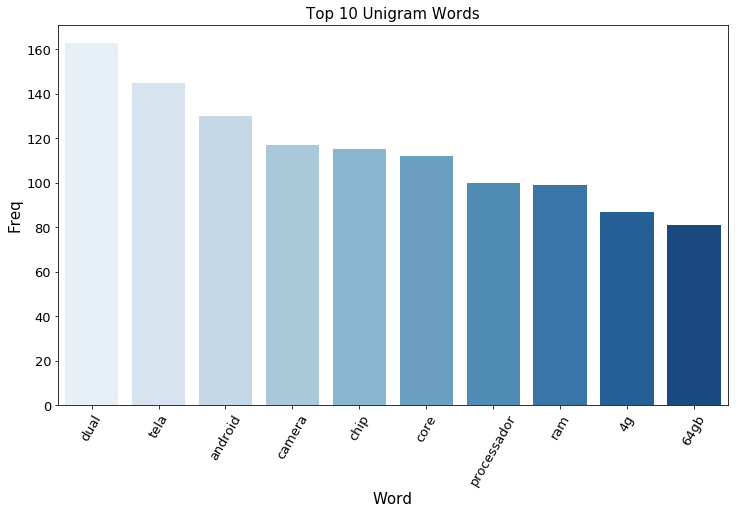

In [14]:
# Plot
ngram_plot(unigram['word'],unigram['freq'],'Top 10 Unigram Words')

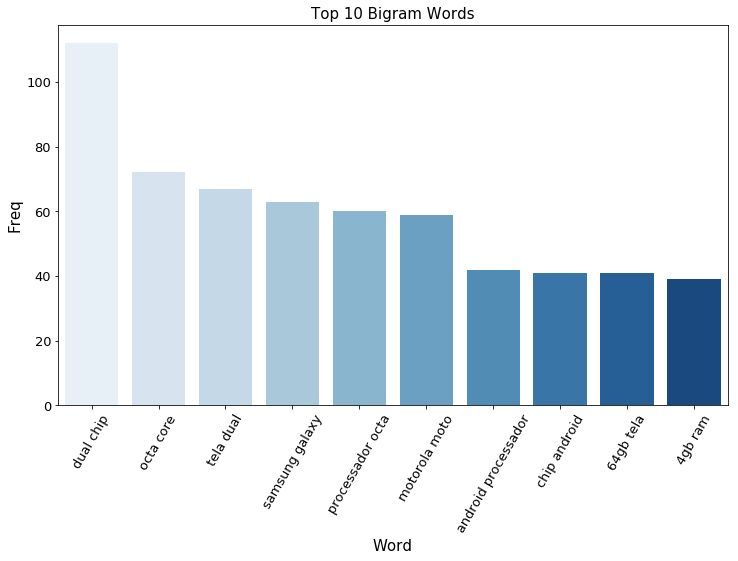

In [15]:
# Plot
ngram_plot(bigram['word'],bigram['freq'],'Top 10 Bigram Words')

You can see that we have many words related with smartphone that are characteristics of it, like camera, chip, core e etc.

In general this top 10 unigram describe what a smartphone have. I think that if some of these words appears in a sentence it's very likely to be a smartphone. Of course we have some problems because one one tablet have very similar words to.

It's interesting to note too that these words in general are related, like dual chip, tela dual, android processador and etc.

Now that we understand this, let's filter again our dataset with these words to check sentences without key smartphone, but that describe one.

In [16]:
'''

Check if each word in a list appear in sentence.

Parameters:
-----------
x: Sentence.
word: List of words to check

Returns:
-----------
True ou False indicanting if exist or not these words.

'''
def check_smart(x,word):
    if (len([True for w in word if ' '+ w +' ' in ' '+ x +' '])>0):
        return True
    else:
        return False

In [17]:
# Unigram with top 20
unigram = ngram(1,smartphone['title'],20)

In [18]:
# Check unigram
unigram

,word,freq
0,dual,163
1,tela,145
2,android,130
3,camera,117
4,chip,115
5,core,112
6,processador,100
7,ram,99
8,4g,87
9,64gb,81


I will use more words to filter (20) but from these words I will remove 'preto' because it's not a good characteristic to describe an smartphone.

In [19]:
# Filter
unigram = unigram[~unigram['word'].map(lambda x: 'preto' in x)]

# Filter by unigram
possibly_smartphone = e_commerce[e_commerce['title'].map(lambda x: check_smart(x,unigram['word']))]

# Filter by possibly_smartphone
e_commerce = e_commerce[~e_commerce.index.isin(possibly_smartphone.index)]

In [20]:
# Check number of samples
possibly_smartphone.shape

(867, 1)

In [21]:
# First 5 lines
possibly_smartphone.head()

,title
46,capa iphone 6 plus muvit
60,pelicula vidro temperado samsung galaxy e7 e700
68,memoria 4gb ddr3 1333 kvr13n9s8/4 kingston
97,bumper ero original samsung galaxy s3 siii i93...
98,bumper ero original galaxy s3 siii i9300 pinge...


You can see that we have sentences related to smartphone, but they don't really talk about one. Actually these sentences describe something that can be used for a smartphone.

Let's check our unigram words in possibly_smartphone.

In [22]:
# Compute unigram
unigram2 = ngram(1,possibly_smartphone['title'],50)

In [23]:
# Remove similar unigram to get words different
unigram2 = unigram2[~unigram2['word'].isin(unigram['word'])]

In [24]:
# Show
unigram2

,word,freq
0,capa,423
5,celular,152
6,tpu,141
9,duos,85
12,pelicula,81
13,iphone,80
14,preto,80
15,transparente,75
17,branco,70
18,s4,69


Note that we have several words that are not interesting like:

- capa
- pelicula
- transparente
- pc
- bumper
- protetora
- cover
- vidro

Some of these words are color and some are things that can be used with a smartphone. So It's likely that sentences with these words don't really describe one smartphone.

Let's check sentences with these words.

In [25]:
# Creating a word list
word_list = ['capa','pelicula','transparente','pc','bumper','protetora','cover','vidro']

In [26]:
# Filter
not_smart = possibly_smartphone[possibly_smartphone['title'].map(lambda x: check_smart(x,word_list))]

# Sort
not_smart = not_smart.sort_values(by='title')

In [27]:
# Show
not_smart

,title
1570,bumber motorola d3 transparente roxo
1595,bumber samsung galaxy s4 rosa transparente
100,bumper ero original galaxy s3 siii i9300 pinge...
114,bumper ero original galaxy s3 siii i9300 pinge...
113,bumper ero original galaxy s3 siii i9300 pinge...
112,bumper ero original galaxy s3 siii i9300 pinge...
110,bumper ero original galaxy s3 siii i9300 pinge...
98,bumper ero original galaxy s3 siii i9300 pinge...
111,bumper ero original galaxy s3 siii i9300 pinge...
109,bumper ero original galaxy s3 siii i9300 pinge...


I check the dataset above and it's very cleary that these words are not related to smartphone. In general they describe things used by one like capa, bumper and pelicula.

In [28]:
# Filter again for not smart
possibly_smartphone = possibly_smartphone[~possibly_smartphone.index.isin(not_smart.index)].copy()

# Sort
possibly_smartphone = possibly_smartphone.sort_values(by='title')

In [29]:
# Show
possibly_smartphone

,title
2209,apple iphone 5s 16gb 4g 100 original promocao ...
2381,apple iphone 6 64gb novo lacrado nota fiscal
2366,apple iphone 6 64gb rfb lacrado oferta imperdi...
2281,apple iphone 7 128gb original 4g nacional 12mp...
2316,apple iphone 7 plus 256gb lacrado garantia ano...
2443,apple iphone 8 64gb lacrado anatel
2334,apple iphone 8 64gb lacrado original red vermelho
2456,apple iphone 8 64gb vitrine garantia 3 meses p...
2479,apple iphone 8 plus 256gb lacrado 1 ano garantia
2342,apple iphone 8 plus 64gb anatel


I check by eye the dataset above and I notice that we have a lot of samples that aren't related to a smartphone. But, we have some key words that talk about one like:

- iphone
- celular
- galaxy
- lg
- xiaomi
- zenfone

In general this words refers to differets marks in market. So let's filter again by these words, doing this we will generate two dataset's, one that are related to smartphone and other that not.

In [30]:
# Word list
word_list = ['iphone','celular','galaxy','lg','xiaomi','zenfone']

# Creating a filter
filter_condition = possibly_smartphone['title'].map(lambda x: check_smart(x,word_list))

In [31]:
# Concat with smart
smartphone = pd.concat([smartphone,possibly_smartphone[filter_condition]])

# Concat not_smart and e_commerce
not_smart = pd.concat([not_smart,e_commerce,possibly_smartphone[~filter_condition]])

# Sort values
smartphone = smartphone.sort_values(by='title')
not_smart = not_smart.sort_values(by='title')

# Set target (1 will be smartphone and 0 not smartphone)
smartphone['target'] = 1
not_smart['target'] = 0

# Save data
pd.concat([smartphone,not_smart]).to_csv('smart_or_not.csv',index=False)

In [32]:
# Check number of samples
print('Not smart:',not_smart.shape[0])
print('Smart:',smartphone.shape[0])

Not smart: 2087
Smart: 519


# 3. Classification

This step we will build a binary classifier to predict if a sentence it's a smartphone or not.

In [33]:
# Reading data
smart_or_not = pd.read_csv('smart_or_not.csv')

So we have a classic problem in our dataset related to unbalanced values. Of course, we are assuming that both datasets are correct, because we labeled them manually.

So assuming this is right we need doing something with this problem, because training one classifier with unbalanced classes will produces (in general) poor results (because of overfitting).

Because of it our aproach it will be like this: Sample 300 rows from both datasets (600 rows) and used it for training. The left (219 smartphone and 1787 not_smartphone) will be used to test.

In [34]:
# Separate dataset in train and test
X_train = smart_or_not[smart_or_not['target'] == 1].sample(300,replace=False,random_state=42)
X_train = pd.concat([X_train,smart_or_not[smart_or_not['target'] == 0].sample(300,replace=False,random_state=42)])
X_test = smart_or_not[~smart_or_not.index.isin(X_train.index)]

# Separate dataset in dependent and independent variables
y_train = X_train['target']
y_test = X_test['target']
X_train = X_train.drop(columns='target')
X_test = X_test.drop(columns='target')

We will use tf-idf to feature extraction.

In [35]:
# Training tf-idf
vectorizer = TfidfVectorizer().fit(X_train['title'])

# Transform data
X_tfidf = vectorizer.transform(X_train['title'])

In [36]:
# Dimensions
X_tfidf.shape

(600, 1343)

Our dimensions it's quite long (1343), so It's a good idea apply some dimensionality reduction in order to avoid overfitting. We will use SVD (truncated) because this function accepts sparses matrisx.

In [37]:
# Creating svd
svd = TruncatedSVD(n_components=X_tfidf.shape[0]).fit(X_tfidf)

In [38]:
'''

Plot the explained variance by svd

Parameters:
-----------

svd: Svd sklearn object fitted.
size: Number of components to plot.
factor: Factor used to cumsum.

'''
def plot_svd(svd,size,factor):
    
    # Creating components
    x_list = [factor*i for i in range(1,size+1)]
    
    # Cumsum
    cumsum = np.cumsum(svd.explained_variance_ratio_)
    
    # Take factor multiplied by each size
    cumsum = cumsum[[factor*i for i in range(1,size+1)]]

    # Creating figure
    fig,ax = plt.subplots(figsize=(15,7))
    ax.set_title('Explained variance by svd')
    ax.plot(x_list,cumsum,marker='o',color='orange',label='Cumulative')
    
    # Rotate in 45 degrees
    for xtick in ax.get_xticklabels():
        xtick.set_rotation(45)
    
    ax.legend()
    plt.show()

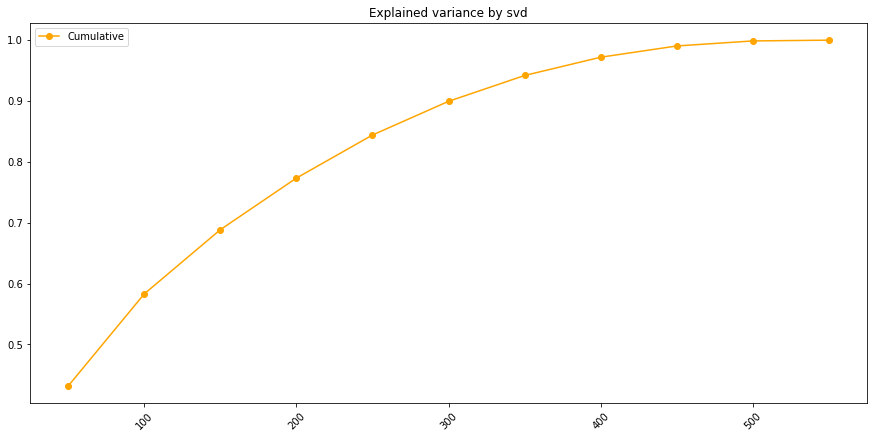

In [39]:
# Plot
plot_svd(svd,11,50)

We have a total of 600 components but with the figure above you can see that with ~350 we have 90% of explained variance. So, let's use just 350 components.

In [40]:
# SVD transform
X_tfidf = svd.transform(X_tfidf)[:,:350]

Now i will apply some classification. For our goals we will use SVM.

In [41]:
# Training
svc = SVC(gamma='scale').fit(X_tfidf,y_train)

In [42]:
# Accuracy
svc.score(X_tfidf,y_train)

0.9683333333333334

Apparently our results are satisfactory.

# 4. Validation

In binary classification we have some trade-off in order to predict correct both classes. So let's evaluate if both of them are predicted correctly.

For check this we will use recall and especifity, beyond kfold for evaluate if our classifier really learn.

In [43]:
# Check samples for each target
y_test.value_counts()

0    1787
1     219
Name: target, dtype: int64

Like you can see above we have a problem with unbalanced data for test. Here we have a similar problem because if we use the dataset in this way, it's very likely to result in poor results in kfold (we don't have much data too). 

So we will undersampling our data, doing this our new dataset will have 438 rows (219 from target 0 and 219 from target 1).

In [44]:
# Sample 219 rows 
y_tmp = y_test[y_test==0].sample(219,replace=False,random_state=42)
y_tmp = pd.concat([y_tmp,y_test[y_test==1]])
X_test = X_test[X_test.index.isin(y_tmp.index)]

In [45]:
# Transforming X_test with tf-idf and svd
X_test = svd.transform(vectorizer.transform(X_test['title']))[:,:350]

In [46]:
'''

Computes specificity

Parameters
----------
estimator: Estimador.
X: Array ou DataFrame com as features.
y: Array com a variável target.

'''
def specificity(estimator,X,y):
    
    # Fit do modelo
    model = estimator.fit(X,y)
    
    # Matrix de confusao
    tn, fp, fn, tp = confusion_matrix(y,model.predict(X)).ravel()
    
    # Especificidade
    return tn/(tn+fp)

In [47]:
# Training
svc = SVC(gamma='scale').fit(X_tfidf,y_train)

In [48]:
# Kfold with 4 folds
cv = ShuffleSplit(n_splits=5,test_size=0.4,random_state=42)

# Evaluation
rec = cross_val_score(svc,X_test,y_tmp,cv=cv,scoring='recall')
spec = cross_val_score(svc,X_test,y_tmp,cv=cv,scoring=specificity)

# Avaliacao
print('Recall:',rec,np.mean(rec),np.std(rec))
print('Specificity:',rec,np.mean(spec),np.std(spec))

Recall: [0.94117647 0.98765432 0.97619048 0.96590909 0.96703297] 0.9675926651416846 0.015345067018218538
Specificity: [0.94117647 0.98765432 0.97619048 0.96590909 0.96703297] 0.8960520271221576 0.13204602122055545


Evaluating the SVM for both recall and specificity we can see that the results are very good. We do not have a high variation in the folds indicating that we do not have overfitting and in addition the average values are very high.

# 5. Tuning

Let's try to improve our model considering that roc_auc it will be our best metric, because with these it's possibly to have good predition in both classes (0 and 1).

In [49]:
# Model for tuning
svc = SVC(gamma='scale')

# Params to test
param_grid={
    'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'kernel': ('linear','rbf','poly','sigmoid')
}

# Creating grid_search
grid_search = GridSearchCV(cv=5,estimator=svc,param_grid=param_grid,scoring='roc_auc')

# Training
grid_search.fit(X_tfidf,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [50]:
# Check best params
grid_search.best_params_

{'C': 0.6, 'kernel': 'linear'}

In [51]:
# Test again the model, but with best params
svc = SVC(gamma='scale',kernel='linear',C=0.6)

In [52]:
# Kfold with 4 folds
cv = ShuffleSplit(n_splits=5,test_size=0.4,random_state=42)

# Evaluation
rec = cross_val_score(svc,X_test,y_tmp,cv=cv,scoring='recall')
spec = cross_val_score(svc,X_test,y_tmp,cv=cv,scoring=specificity)

# Avaliacao
print('Recall:',rec,np.mean(rec),np.std(rec))
print('Specificity:',rec,np.mean(spec),np.std(spec))

Recall: [0.91764706 0.95061728 0.96428571 0.93181818 0.95604396] 0.9440824389843998 0.01698938345019107
Specificity: [0.91764706 0.95061728 0.96428571 0.93181818 0.95604396] 0.9487845422850134 0.012452083750868323


You can see that we have some improvement in Specificity. Now both metrics have ~95% hits.

# 6. Deploy

Knowing that our classifier has had good results, let's build a pipeline and save the algorithm to be used in production. For this we will use almost the entire dataset.

In [53]:
# Objects to use in pipeline
vec = TfidfVectorizer()
svd = TruncatedSVD(n_components=350)
svc = SVC(gamma='scale',kernel='linear',C=0.6)

# Creating pipeline
model = Pipeline([('tf-idf',vec),('svd',svd),('svc',svc)])

In [54]:
# Check unbalanced data
smart_or_not['target'].value_counts()

0    2087
1     519
Name: target, dtype: int64

In [55]:
# Undersampling
X = smart_or_not[smart_or_not['target'] == 0].sample(519,replace=False)
X = pd.concat([X,smart_or_not[smart_or_not['target']==1]])

In [56]:
# Separate variables
y = X['target']
X = X.drop(columns='target')

In [57]:
# Training model
model.fit(X['title'],y)

Pipeline(memory=None,
     steps=[('tf-idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [58]:
# Save model
with open('model.pkl','wb') as f:
    pickle.dump(model,f)